C:\Users\Airly\AppData\Local\Temp\ipykernel_23976\2184834770.py:40: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  states_gdf["centroid"] = states_gdf.geometry.centroid
C:\Users\Airly\AppData\Local\Temp\ipykernel_23976\2184834770.py:41: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  states_gdf["x"] = states_gdf.centroid.x
C:\Users\Airly\AppData\Local\Temp\ipykernel_23976\2184834770.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  states_gdf["y"] = states_gdf.centroid.y
C:\Users\Airly\AppData\Local\Temp\ipykernel_23976\2184834770.py:114: UserWarning: Glyph 11035 (\N{BLA

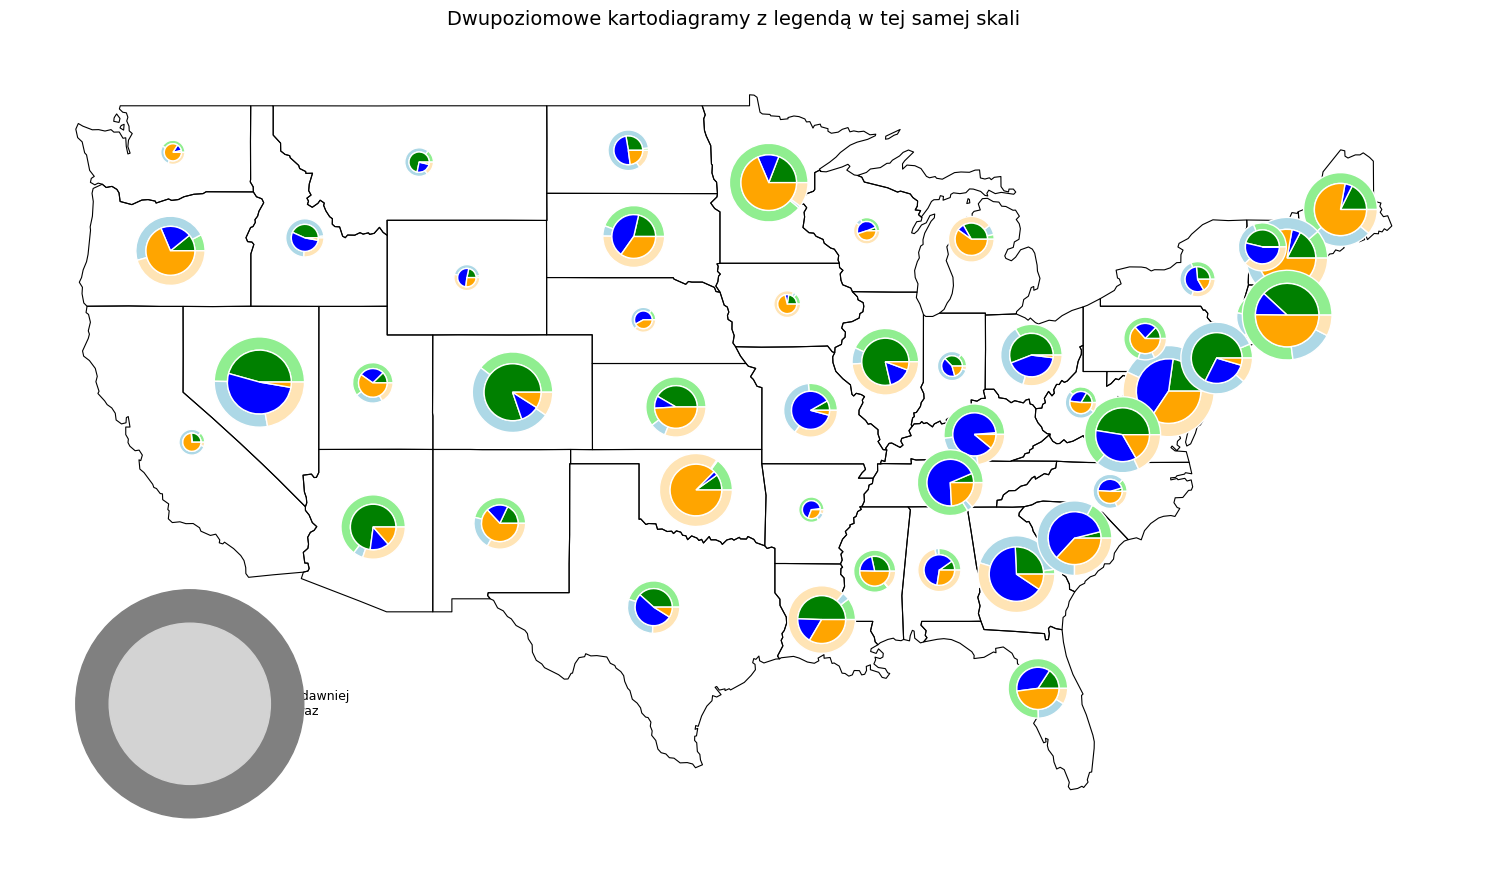

In [9]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Wczytanie danych granic stanów USA
states_gdf = gpd.read_file(r"d:\GIS\us-states.json")

# Ograniczenie do CONUS (bez Alaski i Hawajów)
conus_states = [
    'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
    'Florida', 'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
    'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
    'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
    'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
    'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
    'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'
]
states_gdf = states_gdf[states_gdf["name"].isin(conus_states)].copy()

# Losowanie danych
np.random.seed(42)
now = np.random.dirichlet(np.ones(3), size=len(states_gdf))
past = np.random.dirichlet(np.ones(3), size=len(states_gdf))
size = np.random.uniform(0.1, 0.4, size=len(states_gdf))  # Powierzchnia

# Ramka danych
df = pd.DataFrame({
    "State": states_gdf["name"],
    "Agriculture": now[:, 0],
    "Industry": now[:, 1],
    "Services": now[:, 2],
    "Agriculture2": past[:, 0],
    "Industry2": past[:, 1],
    "Services2": past[:, 2],
    "size": size
})

states_gdf = states_gdf.set_index("name").join(df.set_index("State"))
states_gdf["centroid"] = states_gdf.geometry.centroid
states_gdf["x"] = states_gdf.centroid.x
states_gdf["y"] = states_gdf.centroid.y

# Skala
scale_factor = 40.0

# Tworzenie mapy
fig, ax = plt.subplots(figsize=(15, 10))
states_gdf.geometry.boundary.plot(ax=ax, linewidth=0.8, color='black')

# Rysowanie kół na mapie (z pie chartami)
for _, row in states_gdf.iterrows():
    if pd.isna(row['Agriculture']) or pd.isna(row['Agriculture2']):
        continue

    inner = [row['Agriculture'], row['Industry'], row['Services']]
    outer = [row['Agriculture2'], row['Industry2'], row['Services2']]
    x, y = row['x'], row['y']

    total_area = row['size']
    radius_outer = np.sqrt(total_area / np.pi)
    radius_inner = np.sqrt((total_area / 2) / np.pi)
    size_scaled = radius_outer * scale_factor

    pie_ax = ax.inset_axes([x - size_scaled / 2, y - size_scaled / 2, size_scaled, size_scaled], transform=ax.transData)

    pie_ax.pie(outer, radius=radius_outer,
               colors=["lightgreen", "lightblue", "moccasin"],
               wedgeprops=dict(width=radius_outer - radius_inner, edgecolor='white'))

    pie_ax.pie(inner, radius=radius_inner,
               colors=["green", "blue", "orange"],
               wedgeprops=dict(width=radius_inner, edgecolor='white'))

    pie_ax.set_aspect('equal')
    pie_ax.axis('off')

# ===============================
# LEGENDA – tylko okręgi w skali
# ===============================

# Użyj największego rozmiaru
legend_area = states_gdf["size"].max()
legend_radius_outer = np.sqrt(legend_area / np.pi)
legend_radius_inner = np.sqrt((legend_area / 2) / np.pi)
legend_size = legend_radius_outer * scale_factor

# Pozycja legendy
legend_x = states_gdf.total_bounds[0] + 5
legend_y = states_gdf.total_bounds[1] + 3

# Okręgi jako legenda
legend_ax = ax.inset_axes([legend_x - legend_size / 2, legend_y - legend_size / 2, legend_size, legend_size], transform=ax.transData)

# Zewnętrzny okrąg – dawniej (ciemniejszy szary)
legend_ax.add_patch(plt.Circle((0.5, 0.5), legend_radius_outer, color='gray', zorder=1))

# Wewnętrzny okrąg – teraz (jaśniejszy szary)
legend_ax.add_patch(plt.Circle((0.5, 0.5), legend_radius_inner, color='lightgray', zorder=2))

legend_ax.set_aspect('equal')
legend_ax.axis('off')

# Opis legendy
ax.text(legend_x, legend_y - legend_radius_outer * 1.7,
        "Legenda – zmiana udziału w czasie\n(rozmiar zachowany)", fontsize=9, ha='center')

ax.text(legend_x + legend_radius_outer * 1.3, legend_y + 0.5,
        "⬛ Ciemnoszare: dawniej\n⬜ Jasnoszare: teraz", fontsize=9, ha='left', va='top')

# Tytuł
ax.set_title("Dwupoziomowe kartodiagramy z legendą w tej samej skali", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()
